for i in ['enginetype','carbody','drivewheel','fuelsystem','car_company']:
    print(df_ia[i].value_counts(ascending=True))

# Data Import

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import pandas as pd
df_original = pd.read_csv('/content/gdrive/MyDrive/Datasets/immo_fr_simplon/valeursfoncieres-2020.txt', sep = '|',low_memory=False)

Mounted at /content/gdrive


In [ ]:
#%%time
df_original = pd.read_csv('/content/gdrive/MyDrive/Datasets/immo_fr_simplon/valeursfoncieres-2020.txt', sep = '|',low_memory=False)

# librairies et preprocessing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [5]:
def nan_rate(df:pd.DataFrame):
  return df.isnull().sum()/df.shape[0]

def treshold_na_col(df:pd.DataFrame,treshold:float):
  return [nan_rate(df).index[i] for i in range(nan_rate(df).shape[0]) if nan_rate(df).values[i] > treshold]

def drop_empty_col(df:pd.DataFrame,treshold:float):
  prop_na = nan_rate(df)
  list_index_col = [prop_na.index[i] for i in range(prop_na.shape[0]) if prop_na.values[i] > treshold]
  df.drop(list_index_col, axis = 1,inplace=True)
  return df

def col_to_int(df:pd.DataFrame,col:str):
  df[col] = df[col].astype(int)
  return df

def col_fill_0(df:pd.DataFrame,col:str):
  df[col] = df[col].fillna(0)
  return df

def check_if_can_be_int(df,col):
  for i in df[col].dropna().values:
    if i%1 >0 :
      print(i)
  return

def drop_for_simple(df):
  df = df[['Date mutation','Valeur fonciere','No voie', 'B/T/Q', 'Type de voie',
       'Voie', 'Code postal', 'Commune', 'Code departement','Surface Carrez du 1er lot',
       'Nombre de lots','Type local', 'Surface reelle bati','Nombre pieces principales']]
  return df

In [6]:
df_immo_full = drop_empty_col(df_original,0.99)
df_immo_full.dropna(subset=['Valeur fonciere'],inplace=True)
#df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].fillna(0)
#df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].astype(int)
df_immo_full = drop_empty_col(df_original,0.92)
df_immo_full['Date mutation'] = pd.to_datetime(df_immo_full['Date mutation'])
df_immo_full['No voie'] = df_immo_full['No voie'].astype('Int64')
df_immo_full['Nombre pieces principales'] = df_immo_full['Nombre pieces principales'].astype('Int64')
df_immo_full = df_immo_full.sort_values(['Commune', 'Code postal'], ascending=[True, False])
df_immo_full['Code postal'] = df_immo_full['Code postal'].fillna(method='ffill')
df_immo_full['Code postal'] = df_immo_full['Code postal'].astype('Int64')
df_immo_full['Code postal'] = df_immo_full['Code postal'].astype(str)
df_immo_full['Valeur fonciere'] = df_immo_full['Valeur fonciere'].str.replace(",",".").astype(float)

In [7]:
test_pb = df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Surface terrain'].isna()]
print(df_immo_full.shape)
print(test_pb.shape)
df_immo_full.drop(test_pb.index, inplace=True)
print(df_immo_full.shape)

(2427808, 23)
(171665, 23)
(2256143, 23)


# Rangement

In [125]:
df_immo_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2256143 entries, 1572789 to 1422104
Data columns (total 23 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   No disposition             int64         
 1   Date mutation              datetime64[ns]
 2   Nature mutation            object        
 3   Valeur fonciere            float64       
 4   No voie                    Int64         
 5   Type de voie               object        
 6   Code voie                  object        
 7   Voie                       object        
 8   Code postal                object        
 9   Commune                    object        
 10  Code departement           object        
 11  Code commune               int64         
 12  Section                    object        
 13  No plan                    int64         
 14  1er lot                    object        
 15  Surface Carrez du 1er lot  object        
 16  Nombre de lots             int

In [10]:
nan_rate(df_immo_full)

No disposition               0.000000
Date mutation                0.000000
Nature mutation              0.000000
Valeur fonciere              0.000000
No voie                      0.390702
Type de voie                 0.415874
Code voie                    0.000000
Voie                         0.000071
Code postal                  0.000000
Commune                      0.000000
Code departement             0.000000
Code commune                 0.000000
Section                      0.000035
No plan                      0.000000
1er lot                      0.738310
Surface Carrez du 1er lot    0.911207
Nombre de lots               0.000000
Code type local              0.422420
Type local                   0.422420
Surface reelle bati          0.423041
Nombre pieces principales    0.423041
Nature culture               0.263141
Surface terrain              0.263141
dtype: float64

In [124]:
df_immo_full.head()

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
1572789,1,2020-01-21,Vente,12746.0,<NA>,NaN,B044,LASSAYETES ET BROUSTE,64460,AAST,64,1,ZA,5,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,8497.0
1572864,1,2020-07-02,Vente,192600.0,298,CHE,0045,DABAN FRESCQ,64460,AAST,64,1,B,631,NaN,NaN,0,1.0,Maison,156.0,4,S,631.0
1572865,1,2020-07-02,Vente,192600.0,298,CHE,0045,DABAN FRESCQ,64460,AAST,64,1,B,631,NaN,NaN,0,1.0,Maison,156.0,4,J,1000.0
1578466,1,2020-09-07,Vente,30348.0,<NA>,NaN,B079,MARQUEDEBAT,64460,AAST,64,1,A,10,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,1310.0
1578467,1,2020-09-07,Vente,30348.0,<NA>,NaN,B079,MARQUEDEBAT,64460,AAST,64,1,A,36,NaN,NaN,0,NaN,NaN,NaN,<NA>,T,8640.0


## Managing Nature Mutation

In [138]:
df_immo_full['Nature mutation'].value_counts()

Vente                                 2208280
Echange                                 22697
Vente en l'état futur d'achèvement      15581
Vente terrain à bâtir                    6768
Adjudication                             2676
Expropriation                             141
Name: Nature mutation, dtype: int64

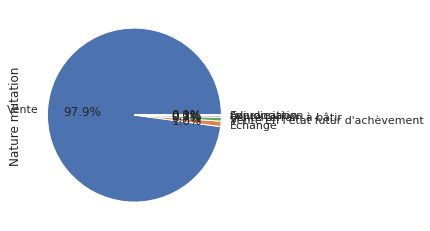

In [139]:
df_immo_full['Nature mutation'].value_counts().plot.pie(autopct="%.1f%%")

## Verification

In [206]:
df_immo_full[df_immo_full['Surface reelle bati'].notna() & df_immo_full['Type local'].isna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain


In [209]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
1511695,1,2020-08-24,Vente,714000.0,11,RUE,0603,DES PLANQUETTES,62217,ACHICOURT,62,4,AX,11,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5900.0
515737,1,2020-04-09,Vente,150000.0,126,RUE,0060,DE PACY,27400,ACQUIGNY,27,3,ZD,362,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,4430.0
1664900,1,2020-09-26,Vente,30000.0,8,NaN,B120,FORGES DE LA BRANLEURE,70320,AILLEVILLERS-ET-LYAUMONT,70,6,A,1611,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,1554.0
1522008,1,2020-12-28,Vente,560000.0,5003,NaN,X011,ZAL DES CHAMPS DU CLER,62160,AIX NOULETTE,62,19,AE,334,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,6583.0
2101485,1,2020-12-03,Vente,158300.0,9012,RUE,0008,D ARLIQUET,87700,AIXE-SUR-VIENNE,87,1,AH,52,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391597,1,2020-06-25,Vente,465000.0,4,ALL,0059,DE LA CLAIRIERE,59136,WAVRIN,59,653,AP,69,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2500.0
400082,1,2020-12-10,Vente,1900000.0,6,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,18,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
400083,1,2020-12-10,Vente,1900000.0,4,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,19,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
691080,1,2020-06-23,Vente,243529.3,3,NaN,B085,ZA DU GRAND CHEMIN,33370,YVRAC,33,554,C,1411,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2070.0


In [208]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna() & df_immo_full['Surface terrain'].isna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain


In [210]:
df_immo_full[df_immo_full['Surface reelle bati'].isna() & df_immo_full['Type local'].notna() & df_immo_full['Nombre pieces principales'].isna()]

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain
1511695,1,2020-08-24,Vente,714000.0,11,RUE,0603,DES PLANQUETTES,62217,ACHICOURT,62,4,AX,11,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5900.0
515737,1,2020-04-09,Vente,150000.0,126,RUE,0060,DE PACY,27400,ACQUIGNY,27,3,ZD,362,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,4430.0
1664900,1,2020-09-26,Vente,30000.0,8,NaN,B120,FORGES DE LA BRANLEURE,70320,AILLEVILLERS-ET-LYAUMONT,70,6,A,1611,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,1554.0
1522008,1,2020-12-28,Vente,560000.0,5003,NaN,X011,ZAL DES CHAMPS DU CLER,62160,AIX NOULETTE,62,19,AE,334,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,6583.0
2101485,1,2020-12-03,Vente,158300.0,9012,RUE,0008,D ARLIQUET,87700,AIXE-SUR-VIENNE,87,1,AH,52,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391597,1,2020-06-25,Vente,465000.0,4,ALL,0059,DE LA CLAIRIERE,59136,WAVRIN,59,653,AP,69,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2500.0
400082,1,2020-12-10,Vente,1900000.0,6,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,18,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
400083,1,2020-12-10,Vente,1900000.0,4,RUE,0150,DE L ECLUSE,22120,YFFINIAC,22,389,AP,19,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,5000.0
691080,1,2020-06-23,Vente,243529.3,3,NaN,B085,ZA DU GRAND CHEMIN,33370,YVRAC,33,554,C,1411,NaN,NaN,0,4.0,Local industriel. commercial ou assimilé,NaN,<NA>,S,2070.0


## Managing Type local

In [141]:
df_immo_full['Type local'].value_counts()

Maison                                      526573
Appartement                                 395722
Dépendance                                  295260
Local industriel. commercial ou assimilé     85547
Name: Type local, dtype: int64

In [8]:
df_immo_full['Type local'] =df_immo_full['Type local'].fillna('none')
df_immo_full_cat = df_immo_full[['Type local']]
from sklearn.preprocessing import OneHotEncoder
cat_local = OneHotEncoder(handle_unknown='ignore')
#cat_local.fit(df_immo_full['Type local'].values.reshape(-1, 1))
df_immo_1hot = cat_local.fit_transform(df_immo_full_cat)
df_1hot = pd.DataFrame(df_immo_1hot.toarray(), columns = ['is_'+i for i in cat_local.categories_[0]])

In [211]:
cat_local.categories_[0]

array(['Appartement', 'Dépendance',
       'Local industriel. commercial ou assimilé', 'Maison', 'none'],
      dtype=object)

In [12]:
df_1hot

,is_Appartement,is_Dépendance,is_Local industriel. commercial ou assimilé,is_Maison,is_none
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2256138,0.0,0.0,0.0,1.0,0.0
2256139,0.0,0.0,0.0,0.0,1.0
2256140,0.0,0.0,0.0,0.0,1.0
2256141,0.0,0.0,0.0,0.0,1.0


In [13]:
nan_rate(df_1hot)

is_Appartement                                 0.0
is_Dépendance                                  0.0
is_Local industriel. commercial ou assimilé    0.0
is_Maison                                      0.0
is_none                                        0.0
dtype: float64

In [14]:
nan_rate(df_immo_full)

No disposition               0.000000
Date mutation                0.000000
Nature mutation              0.000000
Valeur fonciere              0.000000
No voie                      0.390702
Type de voie                 0.415874
Code voie                    0.000000
Voie                         0.000071
Code postal                  0.000000
Commune                      0.000000
Code departement             0.000000
Code commune                 0.000000
Section                      0.000035
No plan                      0.000000
1er lot                      0.738310
Surface Carrez du 1er lot    0.911207
Nombre de lots               0.000000
Code type local              0.422420
Type local                   0.000000
Surface reelle bati          0.423041
Nombre pieces principales    0.423041
Nature culture               0.263141
Surface terrain              0.263141
dtype: float64

<bound method DataFrame.reset_index of          No disposition Date mutation  ... Nature culture  Surface terrain
1572789               1    2020-01-21  ...              T           8497.0
1572864               1    2020-07-02  ...              S            631.0
1572865               1    2020-07-02  ...              J           1000.0
1578466               1    2020-09-07  ...              T           1310.0
1578467               1    2020-09-07  ...              T           8640.0
...                 ...           ...  ...            ...              ...
1421444               1    2020-06-08  ...              S            664.0
1421899               1    2020-01-10  ...              T          27380.0
1421900               1    2020-01-10  ...              T          55110.0
1421901               1    2020-01-10  ...              T            225.0
1422104               2    2020-10-20  ...              T           3430.0

[2256143 rows x 23 columns]>

In [19]:
for i in [df_immo_full, df_1hot]:
  print (i.shape)

(2256143, 23)
(2256143, 5)


In [21]:
df_immo = pd.concat([df_immo_full, df_1hot], axis=1)

In [22]:
df_immo.shape

(2424047, 28)

## Managing Valeur foncière

In [118]:
df_try = df_immo_full.iloc[1:10,:]

In [ ]:
df_try['Valeur fonciere'] = df_try['Valeur fonciere'].astype(str, inplace=True)
df_try['Valeur fonciere'] = df_try['Valeur fonciere'].replace(',','.', inplace=True)

In [ ]:
df_try['Valeur fonciere'].astype(str)
df_try['Valeur fonciere'].replace(',','.', inplace=True)

In [ ]:
df_try

In [ ]:
df_try.info()

## Statistical Outliers

In [130]:
df_vf = df_immo_full.sort_values(['Valeur fonciere'], ascending=True)

In [ ]:
df_vf.loc[df_vf['Valeur fonciere']<500]

# Stuff from before


### Spliting et keys

In [ ]:
# on recupere les colonnes necessaires
df_sample = drop_for_simple(df_sample)
print(df_sample.shape)
df_sample.head(3)

(34169, 14)


,Date mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Voie,Code postal,Commune,Code departement,Surface Carrez du 1er lot,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales
0,2020-02-03,56000.0,190.0,A,RUE,CENTRALE,1370.0,SAINT-ETIENNE-DU-BOIS,1,50.42,1,Appartement,52,2
1,2020-01-02,165000.0,347.0,NaN,RUE,DU CHATEAU,1170.0,CHEVRY,1,48.22,2,Appartement,48,3
2,2020-01-08,720000.0,58.0,NaN,AV,DU MONT BLANC,1220.0,DIVONNE-LES-BAINS,1,130.80,2,Appartement,130,6


In [ ]:
df_sample.columns = ['date', 'valeur', 'no_voie', 'b_t_q', 'type_voie',
       'voie', 'code_postal', 'commune', 'code_departement',
       'surface_carrez_lot1', 'nb_lots', 'type_local',
       'surface_bati', 'nb_pieces']

df_sample.columns


Index(['date', 'valeur', 'no_voie', 'b_t_q', 'type_voie', 'voie',
       'code_postal', 'commune', 'code_departement', 'surface_carrez_lot1',
       'nb_lots', 'type_local', 'surface_bati', 'nb_pieces'],
      dtype='object')

In [ ]:
# Fonctionel mais drop un NAN
df = df_sample
#df = drop_for_simple(df)
df.dropna(subset = ['code_postal'],inplace = True)
df['code_postal'] = df['code_postal'].astype(int)
make_key(df,'T')
df, df_bien = make_s_key(df,['surface_carrez_lot1','surface_bati','nb_pieces','type_local','nb_lots'],'B')
df, df_adresse = make_s_key(df,['b_t_q','no_voie','type_voie','voie','code_postal','commune'],'A')
df_departement = df[['code_postal','code_departement']].drop_duplicates()
df_departement.dropna(inplace=True)
#df_departement['Code postal'] = df_departement['Code postal'].astype(int)
df_transaction = df[['key_T','date','valeur','key_A','key_B']]
df_adresse = df[['key_A','b_t_q','no_voie','type_voie','voie','code_postal','commune']]
df_bien = df[['key_B','surface_carrez_lot1','surface_bati','nb_pieces','type_local','nb_lots','key_A']]


### stuff

In [ ]:
lala = '1250.0'
lala[:-2]

'1250'

In [ ]:
import math
df = df_sample
# df['Code postal'] = df['Code postal'].astype(str)
for i in range(len(df['Code postal'])):
  if math.isnan(df['Code postal'][i])==False:
  #df['Code postal'][i].isna()==False:
    df['Code postal'][i]=int(df['Code postal'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['Code postal'] = df['Code postal'].astype(str)
for i in range(len(df['Code postal'])):
  if len(df['Code postal'][i])>3:
    df['Code postal'][i]=df['Code postal'][i][:-3]


In [ ]:
df

,key_T,Date mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Voie,Code postal,Commune,Code departement,Surface Carrez du 1er lot,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,key_B,key_A
0,0_T,2020-02-03,56000.0,190.0,A,RUE,CENTRALE,1370,SAINT-ETIENNE-DU-BOIS,1,50.42,1,Appartement,52,2,0_B,0_A
1,1_T,2020-01-02,165000.0,347.0,NaN,RUE,DU CHATEAU,1170,CHEVRY,1,48.22,2,Appartement,48,3,1_B,1_A
2,2_T,2020-01-08,720000.0,58.0,NaN,AV,DU MONT BLANC,1220,DIVONNE-LES-BAINS,1,130.80,2,Appartement,130,6,2_B,2_A
3,3_T,2020-01-06,429250.0,140.0,NaN,RUE,DE L'ABBE JOLIVET,1630,PERON,1,109.22,1,Maison,109,5,3_B,3_A
4,4_T,2020-01-07,220900.0,39.0,NaN,RUE,BUFFON,1200,VALSERHONE,1,108.65,2,Appartement,91,4,4_B,4_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34163,34162_T,2020-06-30,2203720.0,53.0,NaN,RUE,MONTMARTRE,75002,PARIS 02,75,99.09,2,Appartement,99,3,34162_B,34162_A
34164,34163_T,2020-06-15,518300.0,6.0,NaN,RUE,DE BRETONVILLIERS,75004,PARIS 04,75,34.51,2,Appartement,35,2,34163_B,34163_A
34165,34164_T,2020-06-30,1290000.0,4.0,NaN,RUE,DE RIVOLI,75004,PARIS 04,75,102.09,1,Appartement,99,3,34164_B,34164_A
34166,34166_T,2020-06-25,420000.0,13.0,NaN,RUE,DES TOURNELLES,75004,PARIS 04,75,32.86,2,Appartement,29,2,34166_B,34165_A


In [ ]:
df_adresse.head()

,key_A,B/T/Q,No voie,Type de voie,Voie,Code postal,Commune
0,0_A,NaN,NaN,NaN,FORTUNAT,1250.0,CEYZERIAT
1,1_A,NaN,NaN,NaN,TERRES DES CINQ SAULES,1290.0,LAIZ
2,2_A,NaN,NaN,NaN,BOIS DU CHAMP RION,1290.0,LAIZ
3,3_A,NaN,NaN,NaN,EN COROBERT,1290.0,LAIZ
6,6_A,NaN,NaN,RUE,DE LA CHARTREUSE,1960.0,PERONNAS


In [ ]:
list_of_df = [df_bien,df_adresse,df_transaction,df_departement]

### DL

In [ ]:
from google.colab import files
for df in list_of_df:
  df.to_csv(df+f'{str}.csv', index = False, header=True) 
  files.download(df+'.csv')

In [ ]:
from google.colab import files
for df in list_of_df:
  df.to_csv(df+'.csv', index = False, header=True) 
  files.download(df+'.csv')

# Start IA

In [214]:
df_immo.drop(columns = 'is_Local industriel. commercial ou assimilé', inplace = True)

In [11]:
nan_rate(df_immo)

No disposition                                 0.069266
Date mutation                                  0.069266
Nature mutation                                0.069266
Valeur fonciere                                0.069266
No voie                                        0.432905
Type de voie                                   0.456334
Code voie                                      0.069266
Voie                                           0.069332
Code postal                                    0.069266
Commune                                        0.069266
Code departement                               0.069266
Code commune                                   0.069266
Section                                        0.069298
No plan                                        0.069266
1er lot                                        0.756436
Surface Carrez du 1er lot                      0.917358
Nombre de lots                                 0.069266
Code type local                                0

In [10]:
df_immo

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Nature culture,Surface terrain,is_Appartement,is_Dépendance,is_Local industriel. commercial ou assimilé,is_Maison,is_none
0,1.0,2020-07-01,Vente,8000.0,<NA>,NaN,B063,FORTUNAT,1250,CEYZERIAT,01,72.0,AK,216.0,NaN,NaN,0.0,NaN,none,NaN,<NA>,T,1061.0,0.0,0.0,0.0,0.0,1.0
1,1.0,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203.0,B,4.0,NaN,NaN,0.0,NaN,none,NaN,<NA>,BT,85.0,0.0,0.0,0.0,1.0,0.0
2,1.0,2020-02-01,Vente,2175.0,<NA>,NaN,B006,BOIS DU CHAMP RION,1290,LAIZ,01,203.0,B,173.0,NaN,NaN,0.0,NaN,none,NaN,<NA>,T,1115.0,0.0,0.0,0.0,1.0,0.0
3,1.0,2020-02-01,Vente,2175.0,<NA>,NaN,B025,EN COROBERT,1290,LAIZ,01,203.0,B,477.0,NaN,NaN,0.0,NaN,none,NaN,<NA>,T,1940.0,0.0,0.0,0.0,0.0,1.0
4,1.0,2020-02-01,Vente,2175.0,<NA>,NaN,B124,TERRES DES CINQ SAULES,1290,LAIZ,01,203.0,C,68.0,NaN,NaN,0.0,NaN,none,NaN,<NA>,T,1148.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459555,1.0,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104.0,AW,19.0,NaN,NaN,0.0,2.0,Appartement,87.0,4,S,447.0,NaN,NaN,NaN,NaN,NaN
2459556,1.0,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104.0,AW,19.0,NaN,NaN,0.0,3.0,Dépendance,0.0,0,S,447.0,NaN,NaN,NaN,NaN,NaN
2459557,1.0,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104.0,AW,19.0,NaN,NaN,0.0,2.0,Appartement,82.0,2,S,447.0,NaN,NaN,NaN,NaN,NaN
2459558,1.0,2020-12-16,Vente,1937500.0,24,RUE,1748,CHANOINESSE,75004,PARIS 04,75,104.0,AW,19.0,NaN,NaN,0.0,3.0,Dépendance,0.0,0,S,447.0,NaN,NaN,NaN,NaN,NaN
